## Model Predictive Control (MPC) of a Quadcopter

The MPC formulation can be written as following
$$\begin{equation}
    \begin{aligned}
    \min_{u_k} \quad &  \sum_{k=0}^{T-1} J \left( x_k, u_k \right)\\
    \text{subject to} \quad & \dot{x}(t) = f(t, x(t), {u(t)})\\
    &x(0) = x_0\\
    & t \in \mathcal{T}
    \end{aligned}
\end{equation}$$
where $J$ is a cost function and $T \in \mathcal{T}$ is the _receding horizon_ over which predicted future trajectories are optimized

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append(2*'../') # go n dirs back
import matplotlib.pyplot as plt

import torch
from torchcontrol.systems import Quadcopter
from torchcontrol.cost import IntegralCost
from torchcontrol.controllers import *
from torchcontrol.mpc import TorchMPC
from torchcontrol.plotting import *


The quadcopter model is a suitably modified version of the explicit dynamics update of [https://arxiv.org/abs/2103.02142](https://arxiv.org/abs/2103.02142) for batched training in PyTorch. The following accelerations update describes the dynamic model
$$\begin{equation}
\begin{aligned}
    \mathbf{\ddot{x}} &= \left( \mathbf{R} \cdot [0,0,k_F{\textstyle\sum}_{i=0}^3 \omega_{i}^2] - [0,0,m g] \right) m^{-1} \\
    \boldsymbol{\ddot{\psi}} &= \mathbf{J}^{-1} \left(
    \tau ( l, k_F, k_T, [\omega_{0}^2, \omega_{1}^2, \omega_{2}^2, \omega_{3}^2])
    - \boldsymbol{\dot{\psi}} \times \left( \mathbf{J} \boldsymbol{\dot{\psi}} \right) \right)
\end{aligned}
\end{equation}$$

where $\mathbf{\boldsymbol{x}} = [x, y, z]$ corresponds to the drone positions and $\boldsymbol{\psi} = [\phi,\theta, \psi]$ to its angular positions; $\boldsymbol{R}$ and $\boldsymbol{J}$ are its rotation and inertial matrices respectively, $\tau(\cdot)$ is a function calculating the torques induced by the motor speeds $\omega_i$, while arm length $l$, mass $m$, gravity acceleration constant $g$ along with $k_F$ and $k_T$ are scalar variables describing the quadcopter's physical properties.

$\Longrightarrow$ The model has 12 variables in total!

In [2]:
?? Quadcopter

Init signature:  Quadcopter(*args, **kwargs)
Source:        
class Quadcopter(ControlledSystemTemplate):
    '''
    Quadcopter state space model compatible with batch inputs
    Appropriately modified version to run efficiently in Pytorch
    References and kudos to:
    Learning to Fly—a Gym Environment with PyBullet Physics for
Reinforcement Learning of Multi-agent Quadcopter Control
    https://arxiv.org/pdf/2103.02142 
    '''
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Parameters
        self.G = 9.81
        self.RAD2DEG = 180/np.pi
        self.DEG2RAD = np.pi/180
        self.M = 0.027
        self.L = 0.0397
        self.THRUST2WEIGHT_RATIO = 2.25
        self.J = torch.diag(torch.Tensor([1.4e-5, 1.4e-5, 2.17e-5]))
        self.J_INV = torch.linalg.inv(self.J)
        self.KF = 3.16e-10
        self.KM = 7.94e-12
        self.GRAVITY = self.G*self.M
        self.HOVER_RPM = np.sqrt(self.GRAVITY / (4*self.KF))
        self.MAX_R

In [3]:
# Change device according to your configuration
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') # feel free to change :)
device = torch.device('cpu') # override

## Cost function
We want the drone to reach position $[x, y, z]$ = $[3, 3, 3]~m$ while the other variables should be 0 (meaning: no rotation and velocities)

Note: finding good values for the cost function is hard - many times, it requires patience and lots of trials and error

In [4]:
# Declaring the cost function
x_star = torch.Tensor([3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]).to(device)
u_star = 0.

P = torch.Tensor([0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).to(device)
Q = torch.Tensor([1, 1, 1, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]).to(device)
R = 0.
cost_function = IntegralCost(x_star=x_star, u_star=u_star, P=P, Q=Q, R=R)

## Initial Conditions
We start with all the variables at 0

In [5]:
x0, y0, z0 = 0., 0., 0.
phi0, theta0, psi0 = 0., 0., 0.

init = torch.tensor([x0,
                    y0,
                    z0,
                    phi0,
                    theta0,
                    psi0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0], dtype=torch.float).to(device)
print(init)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


## Controller
We use the neural box-constrained controller with output scaling

In [6]:
# Instantiate drone
drone = Quadcopter(None, solver='euler') # dummy controller
scaling = torch.Tensor([0, drone.MAX_RPM])
controller = BoxConstrainedController(12, 4, output_scaling=scaling, constrained=True)
drone.u = controller # controller for the drone


## MPC initialization

In [7]:
# MPC simulation variables
dt = 0.02 # time stef
tf = 2 # final time
t_span = torch.linspace(0, tf, int(tf/dt)+1)
lr = 1e-2 # learning rate
weight_decay = 1e-4 # weight decay for adam
steps_nom = 5 # nominal steps to do between each MPC step
max_iters = 20 # maximum SGD iteration / sampling step
eps_accept = 1e-3 # stop subproblem solution when this loss is reached
lookahead_steps = 25 # receding horizon
x0 = init # initial state

# Optimizer
opt = torch.optim.Adam(controller.parameters(), lr=lr, weight_decay=weight_decay)

# Instantiate MPC
mpc = TorchMPC(drone, cost_function, t_span, opt, eps_accept=eps_accept, max_g_iters=max_iters,
            lookahead_steps=lookahead_steps, lower_bounds=None,
            upper_bounds=None, penalties=None).to(device)

## MPC simulation
For simulating the MPC we need a system with an accurate solver, e.g. `dopri5` for carrying forward the solutions

In [8]:
drone_nominal = Quadcopter(RandConstController((1,1),1,1), solver='dopri5', atol=1e-5, rtol=1e-5)
loss = mpc.forward_simulation(drone_nominal, x0, t_span, reset=True, reinit_zeros=False)

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Starting simulation...


Steps: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s, cost=0.145, timestamp=2, converged=0]

The simulation has ended!


In [9]:
# Get variables
traj = mpc.trajectory_nominal
controls = mpc.control_inputs 
print('Nominal cost:', loss)

Nominal cost: tensor(1.6980)


## Plotting

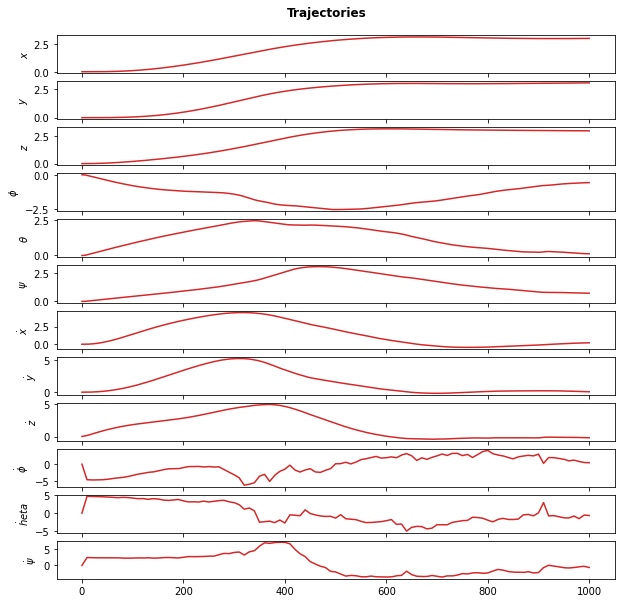

In [10]:
plot_quadcopter_trajectories(traj)

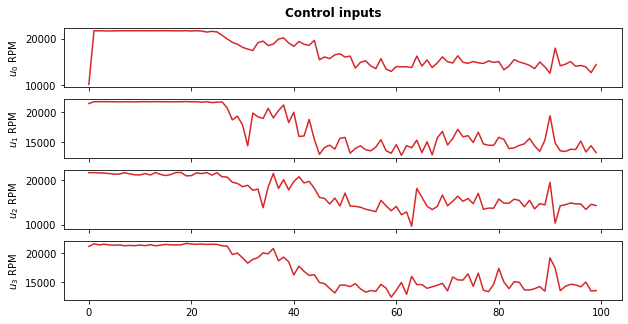

In [11]:
plot_quadcopter_controls(controls)

In [12]:
# Here we reduce the resolution of the trajectory, so the plotter 'skips' 
# some points and take less time

import numpy as np
# MPC trajectory: plot every 0.02s 
skip = 20 # we skip 20 frams at a time
t = []
for i in range(int(traj.shape[0]/skip)):
    t.append(traj[i*skip,:][None])

trajs_reduced = np.concatenate(t)
t_span = torch.linspace(0, 2, trajs_reduced.shape[0]+1)

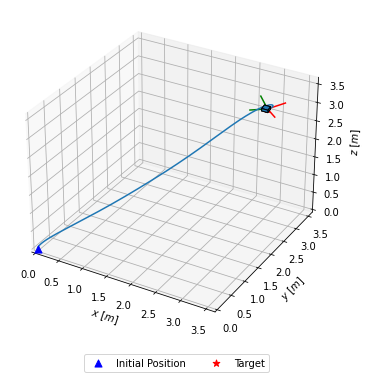

In [13]:
plot_quadcopter_trajectories_3d(traj, x_star, i=len(traj))

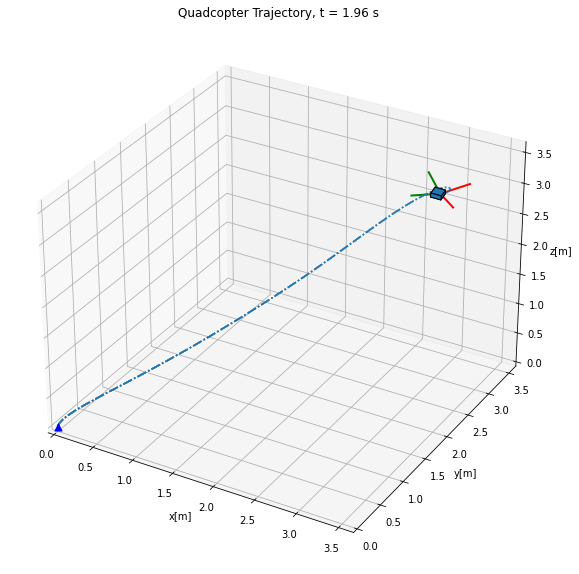

In [14]:
animate_quadcopter_3d(trajs_reduced, x_star, t_span)